In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

data=pd.read_csv("https://drive.google.com/uc?export=download&id=1LU5be_H1TD2Pp1OmI202to3YyKo9AzFY")
  
print(data.head())


  country  age  new_user source  total_pages_visited  converted
0      UK   25         1    Ads                    1          0
1      US   23         1    Seo                    5          0
2      US   28         1    Seo                    4          0
3   China   39         1    Seo                    5          0
4      US   30         1    Seo                    6          0


country : user country based on the IP address

age : user age. Self-reported at sign-up step

new_user : whether the user created the account during this session or had already an account and simply came back to the site

source : marketing channel source Ads: came to the site by clicking on an advertisement Seo: came to the site by clicking on search results Direct: came to the site by directly typing the URL on the browser

total_pages_visited: number of total pages visited during the session. This can be seen as a proxy for time spent on site and engagement

converted: this is our label. 1 means they converted within the session, 0 means they left without buying anything. The company goal is to increase conversion 

rate: # conversions / total sessions

# Descriptive Statistics

In [2]:
print(data.describe())

                 age       new_user  total_pages_visited      converted
count  316200.000000  316200.000000        316200.000000  316200.000000
mean       30.569858       0.685465             4.872966       0.032258
std         8.271802       0.464331             3.341104       0.176685
min        17.000000       0.000000             1.000000       0.000000
25%        24.000000       0.000000             2.000000       0.000000
50%        30.000000       1.000000             4.000000       0.000000
75%        36.000000       1.000000             7.000000       0.000000
max       123.000000       1.000000            29.000000       1.000000


In [3]:
print(data.groupby(['country']).size())

country
China       76602
Germany     13056
UK          48450
US         178092
dtype: int64


In [4]:
print(data.groupby(['source']).size())

source
Ads        88740
Direct     72420
Seo       155040
dtype: int64


# Data Cleaning

In [5]:
print(sorted(data['age'].unique(), reverse=True))

[123, 111, 79, 77, 73, 72, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17]


In [6]:
print(data[data['age']>110])

        country  age  new_user source  total_pages_visited  converted
90928   Germany  123         0    Seo                   15          1
295581       UK  111         0    Ads                   10          1


remove the 2 rows

In [7]:
data = data[data['age']<110]

# Descriptive Stat Graphs

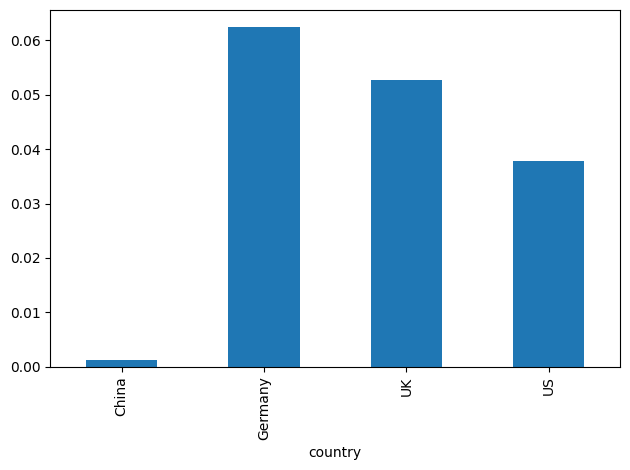

In [8]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams.update({'figure.autolayout':True})

data.groupby(['country'])['converted'].mean().plot.bar()
plt.show()

China convert rate is really low

<function matplotlib.pyplot.show(close=None, block=None)>

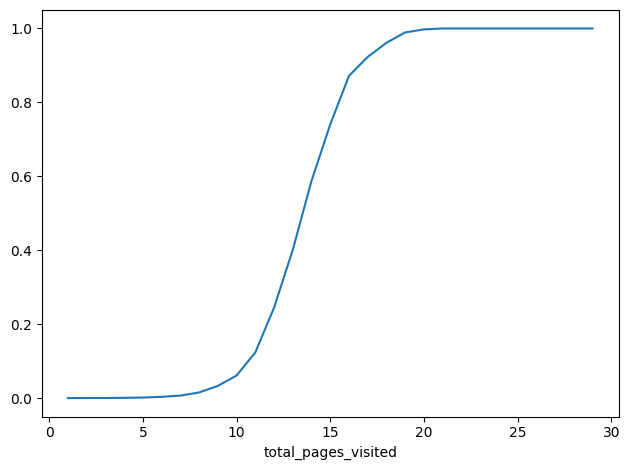

In [9]:
data.groupby(['total_pages_visited'])['converted'].mean().plot()
plt.show

more time on site = higher conversion

non-linear 

most likely to convert if visit more than 10 pages

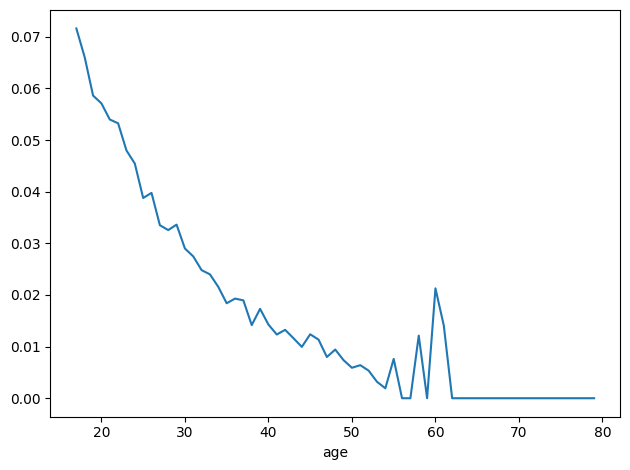

In [10]:
data.groupby(['age'])['converted'].mean().plot()
plt.show()

younger users are more likely to convert

though intestesting, 60 yos are equally as likely to convert as 30 yos

<function matplotlib.pyplot.show(close=None, block=None)>

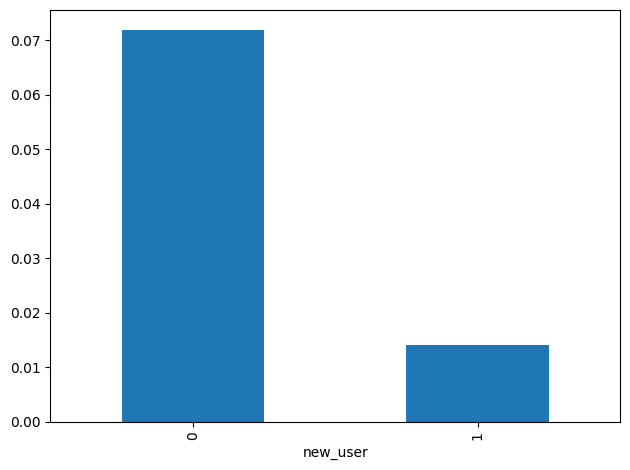

In [11]:
data.groupby(['new_user'])['converted'].mean().plot.bar()
plt.show

existing user are almost 4x likely to convert

<function matplotlib.pyplot.show(close=None, block=None)>

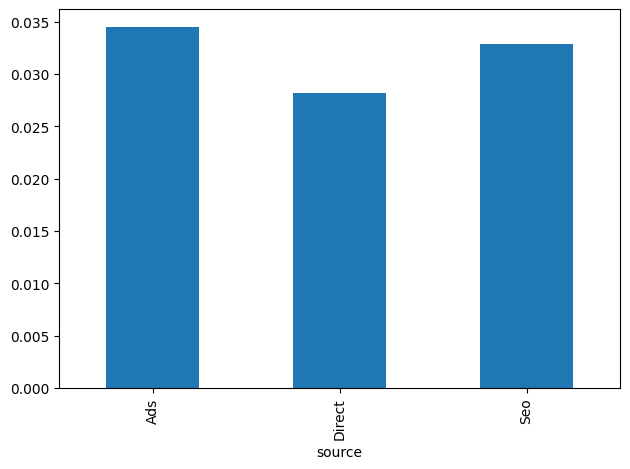

In [12]:
data.groupby(['source'])['converted'].mean().plot.bar()
plt.show

ads and seo equally likely to convert

# Preparation

In [13]:

data_dummy = pd.get_dummies(data,drop_first = True)
print()

In [14]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

np.random.seed(4686)

#split data
train, test = train_test_split(data_dummy, test_size = 0.34)
print(train.head())
#build model
rf = RandomForestClassifier(n_estimators = 100, max_features=3, oob_score=True)
rf.fit(train.drop('converted', axis =1), 
       train['converted'])


        age  new_user  total_pages_visited  converted  country_Germany  \
144637   22         0                    5          0            False   
203326   18         1                    1          0            False   
15015    29         0                    9          0            False   
228664   23         1                    1          0            False   
128629   32         1                    4          0            False   

        country_UK  country_US  source_Direct  source_Seo  
144637        True       False          False       False  
203326        True       False          False       False  
15015         True       False          False       False  
228664       False       False           True       False  
128629       False        True          False        True  


RandomForestClassifier(max_features=3, oob_score=True)

In [15]:
print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(train['converted'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.9841247783794145 
 OOB Confusion Matrix 
         0     1
0  200835  1088
1    2224  4543


In [16]:
print(
"Test accuracy is", rf.score(test.drop('converted', axis=1),test['converted']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(test['converted'], rf.predict(test.drop('converted', axis=1)), labels=[0, 1]))
)

Test accuracy is 0.9847453212784165 
 Test Set Confusion Matrix 
         0     1
0  103532   545
1    1095  2336


OOB error and test error are similar. model is not overfitting

**check feature importances:**

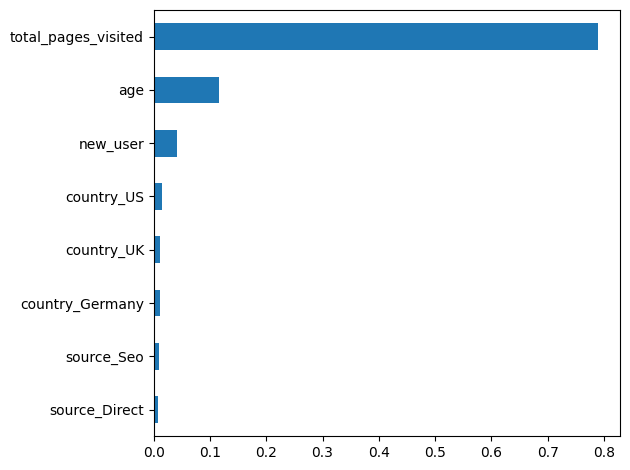

In [17]:
feat_importances = pd.Series(rf.feature_importances_,
                            index = train.drop('converted',axis =1).columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

**re-build model and drop total_pages_visited:**

In [18]:
rf = RandomForestClassifier(n_estimators = 100,
                           max_features = 3,
                           oob_score = True,
                           class_weight = {0:1, 1:10})
rf.fit(train.drop(['converted','total_pages_visited'], axis =1), train['converted'])

print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(train['converted'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.8884182279936749 
 OOB Confusion Matrix 
         0      1
0  182330  19593
1    3693   3074


In [19]:
print(
"Test accuracy is", 
rf.score(test.drop(['converted','total_pages_visited'], axis =1), test['converted']), 
"\n", 
"Test Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(test['converted'], 
                              rf.predict(test.drop(['converted', 'total_pages_visited'], axis=1)), 
                              labels=[0, 1])))

Test accuracy is 0.8885199240986718 
 Test Confusion Matrix 
        0      1
0  93999  10078
1   1907   1524


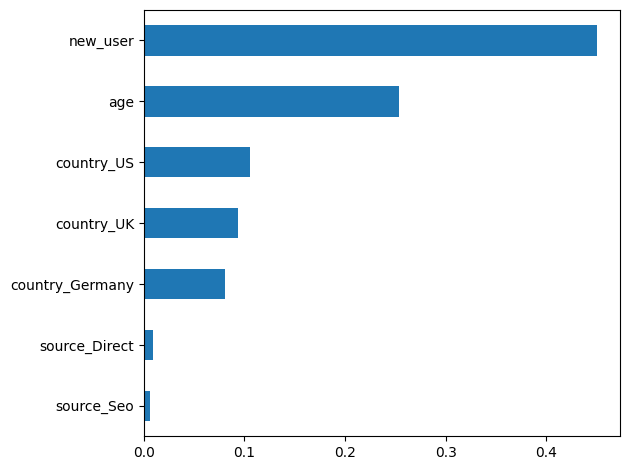

In [20]:
feat_importances = pd.Series(rf.feature_importances_, 
                             index = train.drop(['converted','total_pages_visited'], axis =1).columns)
feat_importances.sort_values().plot(kind= 'barh')
plt.show()

new user became the most important variable

# Partial Dependent Plots

PDP plots below treat categorical variables as numerical becasue they were OH encoded. Hence the line plot, instead of bar.

Solution: leave cat cols as they are, no OH encoding. But will need to redo the tree. A good reference: https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html



In [21]:
from matplotlib import pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

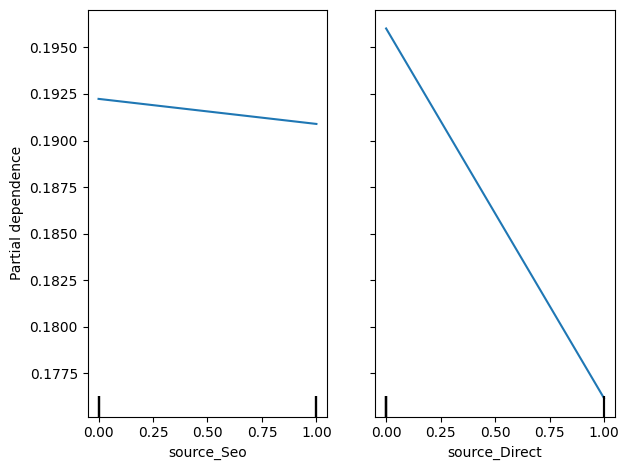

In [22]:
#source
f_names = ['source_Seo','source_Direct']
disp1 = PartialDependenceDisplay.from_estimator(rf,  
                                            train.drop(['converted','total_pages_visited'], axis=1),
                                            f_names,
                                            
                                               )
plt.show()

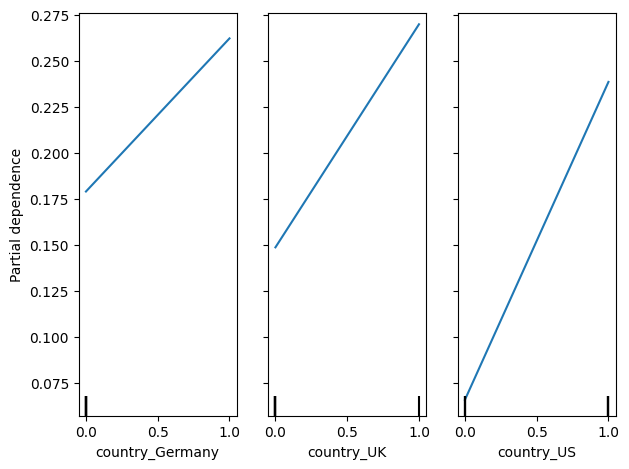

In [23]:
#country
f_names = ['country_Germany', 'country_UK','country_US']
disp2 = PartialDependenceDisplay.from_estimator(rf,  
                                            train.drop(['converted','total_pages_visited'], axis=1),
                                            f_names
                                               )
plt.show()

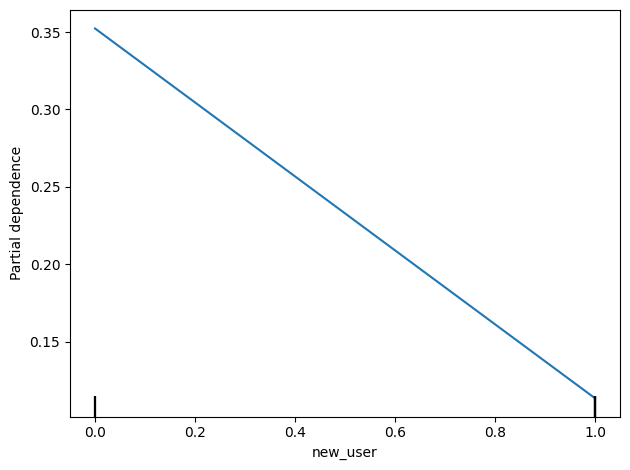

In [24]:
#new user
f_names = ['new_user']
disp3 = PartialDependenceDisplay.from_estimator(rf,  
                                            train.drop(['converted','total_pages_visited'], axis=1),
                                            f_names
                                               )
plt.show()

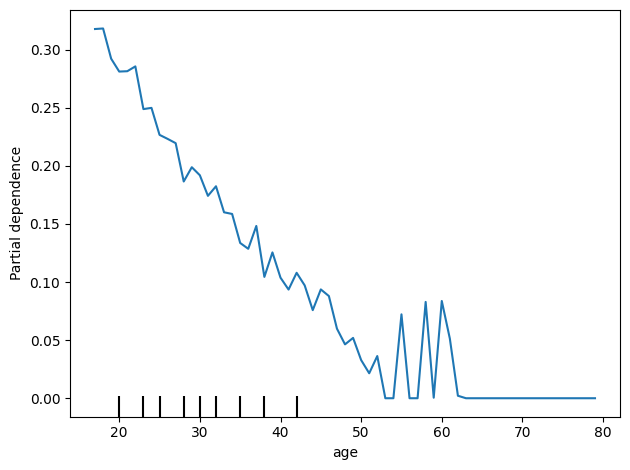

In [25]:
#age
f_names = ['age']
disp4 = PartialDependenceDisplay.from_estimator(rf,  
                                            train.drop(['converted','total_pages_visited'], axis=1),
                                            f_names
                                               )
plt.show()

**insights**

source PDP are both quite low compared to other features

the other 3 features:

1. country: Everyone but China has high value. If one is not from China, there's a high prob of conveting

2. new_user: user with exsting account more likely to convert

3. age: if user age>30, less likely to convert


In [26]:
# Anther way of plotting PDP that could potentially work. Not currently working
# pip install pdpbox
# from pdpbox import pdp, info_plots

# pdp_iso = pdp.PDPIsolate( model=rf, 
#                           df=train.drop(['converted', 'total_pages_visited'], axis=1),      
#                           model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
#                           feature="source_Direct", 
#                          feature_name = "source",
#                           num_grid_points=50)
# fig, axes = pdp_iso.plot(
#     center=False,
#     plot_lines=True,
#     frac_to_plot=100,
#     cluster=False,
#     n_cluster_centers=None,
#     cluster_method='accurate',
#     plot_pts_dist=True,
#     to_bins=False,
#     show_percentile=False,
#     which_classes=None,
#     figsize=None,
#     dpi=300,
#     ncols=2,
#     plot_params={"pdp_hl": True},
#     engine='plotly',
#     template='plotly_white',
# )
# fig.update_xaxes(row=2, col=1)

# Conclusion and Recommendations
Biggest hits to improve conversion rate:
1. Age

    1.1 increasing marketing to younger users, and find channels that younder users are likely to use, i.e. social media instead of SEO. 
    
    1.2 for older users, figure out why they are converting so poorly. Is UI bad? Is it too complicated to them to use?

2. Country

    2.1 German has high chance of converting, but there are the least amount of German users. Why are traffic from Germany low? Get more traffic by increasing marketing

    2.2 China has traffic but is converting terribly. What's wrong with the site? Is translation terrible? Loading too slow? UI not conventional to local culture?

3. new user
    
    3.1 Target returing users. Maybe send email with offers?

